In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# December 2024
# License: MIT

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100000, n_features=10, n_informative=2, n_redundant=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.svm import LinearSVC

class MinMaxCalibratedSVC(LinearSVC):
    """LinearSVC with naively scaled decision scores using min-max scaling."""
    
    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        df = self.decision_function(X)

        # Apply min-max scaling to the decision scores
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)    

        # Clip values to [0, 1] to handle potential rounding errors
        proba_pos_class = np.clip(calibrated_df, 0, 1)  
        proba_neg_class = 1 - proba_pos_class

        # Combine probabilities for both classes
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define a list of classifiers to evaluate their calibration performance
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('SVC (MinMax Calibrated)', MinMaxCalibratedSVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(min_samples_leaf=5, random_state=42)),    
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

In [6]:
from sklearn.calibration import CalibrationDisplay

def generate_calibration_plots(classifiers, X_train, y_train, X_test, y_test):
    # Define the figure and add a single subplot
    fig = plt.figure()
    ax_calibration_curve = fig.add_subplot()  
    colors = plt.get_cmap('Dark2')
    markers = ['^', 'v', 's', 'o', 'p']
    
    for i, (name, clf) in enumerate(classifiers):
        # Fit classifier and generate calibration plot
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf, X_test, y_test, n_bins=10, name=name, ax=ax_calibration_curve,
            color=colors(i), marker=markers[i]
        )       
    plt.grid(alpha=0.5)

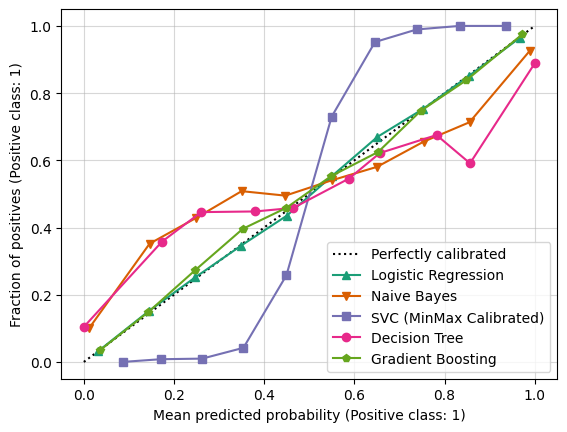

In [7]:
generate_calibration_plots(classifiers, X_train, y_train, X_test, y_test)
plt.savefig('figures/calibration_plot.pdf')

Platt Scaling

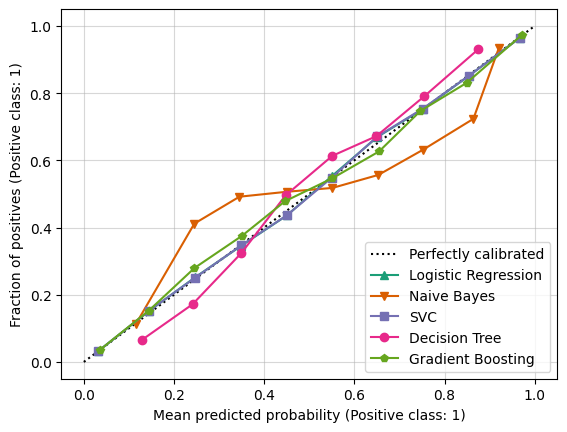

In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Define base estimators
base_classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('SVC', LinearSVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(min_samples_leaf=5, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Apply Platt scaling to each classifier
classifiers = [(name, CalibratedClassifierCV(estimator, cv=3)) 
               for name, estimator in base_classifiers]

# Generate calibration plots
generate_calibration_plots(classifiers, X_train, y_train, X_test, y_test)
plt.savefig('figures/platt_scaling.pdf')

Isotonoic Regression

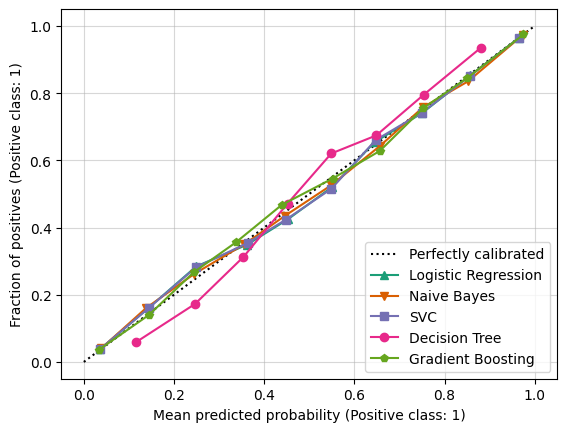

In [9]:
# Define base estimators
base_classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('SVC', LinearSVC(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(min_samples_leaf=5, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Apply isotonic regression to each classifier
classifiers = [(name, CalibratedClassifierCV(estimator, method='isotonic', cv=3)) 
               for name, estimator in base_classifiers]

# Generate calibration plots
generate_calibration_plots(classifiers, X_train, y_train, X_test, y_test)
plt.savefig('figures/isotonic_regression.pdf')